In [1]:
# import dependencies
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random

import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras

In [2]:
# load data
data = []
pathlist = Path('Samples2').glob('*.mat')
for p in pathlist:
  mat_dict = loadmat(str(p))
  data.append(mat_dict['samples'])

# shuffle data
random.shuffle(data)

In [3]:
# separate x and y data
x_values = []
y_values = []

KNOB_SET = 0.01

for d in data:
    if d[0][1][0] == KNOB_SET:
        x_values.append(d[0][0])
        y_values.append(d[0][2])

x_values = np.asarray(x_values) - 4.5
y_values = np.asarray(y_values) - 4.5
print(np.shape(x_values))
print(np.shape(y_values))

(81, 8820)
(81, 8820)


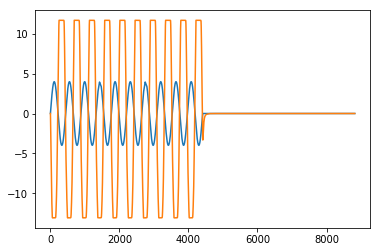

In [7]:
# plot sample data point
idx = 42
plt.plot(x_values[idx])
plt.plot(y_values[idx])
plt.show()

In [8]:
# use float32 data type...
x_values = x_values.astype(np.float32)
y_values = y_values.astype(np.float32)

In [9]:
# split into training and validation data
NUM_TRAIN = 70
NUM_VAL = 11
x_train, x_val = np.split(x_values, [NUM_TRAIN])
y_train, y_val = np.split(y_values, [NUM_TRAIN])

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))

(70, 8820)
(11, 8820)
(70, 8820)


In [45]:
# reshape data
IN_train    = np.reshape(x_train, (NUM_TRAIN, 8820, 1))
IN_validate = np.reshape(x_val,   (NUM_VAL,  8820, 1))

OUT_train    = np.reshape(y_train, (NUM_TRAIN, 8820, 1))
OUT_validate = np.reshape(y_val,   (NUM_VAL,  8820, 1))

print(np.shape(IN_train))

(70, 8820, 1)


In [55]:
model = tf.keras.Sequential()

# GRU Layer
model.add(keras.layers.GRU(units=16, input_shape=(8820,1), return_sequences=True, bias_initializer='zeros'))

# Final layer is 1 neuron -> single value output
model.add(keras.layers.Dense(1))

# Adam optimizer
opt = keras.optimizers.Adam(learning_rate=5.0e-4)

# Error-to-Signal ratio loss function
def esr_loss(target_y, predicted_y):
  return tf.reduce_sum(tf.square(target_y - predicted_y)) / tf.reduce_sum(tf.square(target_y))

model.compile(optimizer=opt, loss=esr_loss, metrics=['mse'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 8820, 16)          912       
_________________________________________________________________
dense_6 (Dense)              (None, 8820, 1)           17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(IN_train, OUT_train, epochs=500, validation_data=(IN_validate, OUT_validate))

Train on 70 samples, validate on 11 samples
Epoch 1/500
70/70 [==============================] - 23s 328ms/sample - loss: 1.0110 - mse: 15.8033 - val_loss: 1.0051 - val_mse: 26.6803
Epoch 2/500
70/70 [==============================] - 23s 334ms/sample - loss: 1.0028 - mse: 15.6729 - val_loss: 0.9966 - val_mse: 26.4558
Epoch 3/500
70/70 [==============================] - 24s 336ms/sample - loss: 0.9950 - mse: 15.5543 - val_loss: 0.9882 - val_mse: 26.2335
Epoch 4/500
70/70 [==============================] - 23s 334ms/sample - loss: 0.9871 - mse: 15.4257 - val_loss: 0.9800 - val_mse: 26.0145
Epoch 5/500
70/70 [==============================] - 23s 334ms/sample - loss: 0.9788 - mse: 15.2980 - val_loss: 0.9718 - val_mse: 25.7975
Epoch 6/500
70/70 [==============================] - 23s 335ms/sample - loss: 0.9709 - mse: 15.1707 - val_loss: 0.9637 - val_mse: 25.5816
Epoch 7/500
70/70 [==============================] - 22s 312ms/sample - loss: 0.9638 - mse: 15.0615 - val_loss: 0.9556 - val_mse

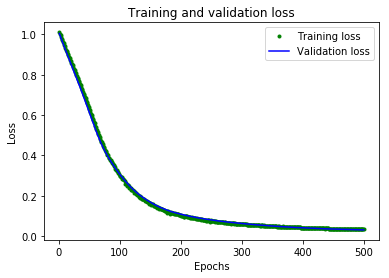

In [57]:
# plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

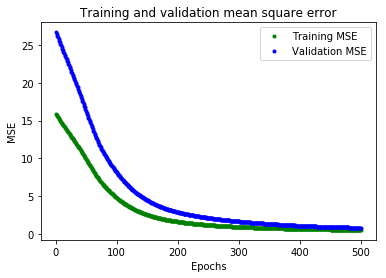

In [61]:
# plot error
plt.clf()
mse = history.history['mse']
val_mse = history.history['val_mse']

plt.plot(epochs, mse, 'g.', label='Training MSE')
plt.plot(epochs, val_mse, 'b.', label='Validation MSE')
plt.title('Training and validation mean square error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

(1, 8820, 1)


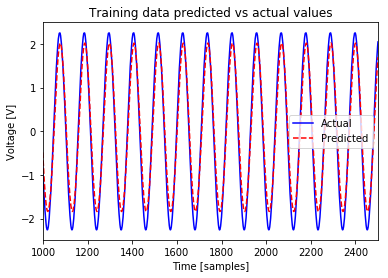

In [64]:
# Test prediction
idx = 2
predictions = model.predict(x_train[idx].reshape(1, 8820, 1))

print(np.shape(predictions))

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(y_train[idx], 'b', label='Actual')
plt.plot(predictions.flatten(), 'r--', label='Predicted')
plt.legend()
plt.xlim(1000, 2500)
plt.xlabel('Time [samples]')
plt.ylabel('Voltage [V]')
plt.show()

In [65]:
# Export weights....
print('GRU Kernel Weights...')
print(model.weights[0].numpy())

print('GRU Recurrent Weights...')
print(model.weights[1].numpy())

print('GRU bias...')
print(model.weights[2].numpy())

print('Dense Kernel Weights...')
print(model.weights[3].numpy())

print('Dense bias...')
print(model.weights[4].numpy())

GRU Kernel Weights...
[[ 0.11278465  0.18422566  0.02588048 -0.19798496 -0.00439443 -0.14536698
  -0.05871213  0.05862301 -0.21124566  0.09156726  0.11798698  0.29000708
  -0.22593777  0.02777318 -0.16820474  0.1555053   0.08541053  0.2172122
   0.02365478 -0.13997027 -0.23096782  0.36191943  0.43721986  0.51476485
   0.01098049 -0.33033827  0.06522381 -0.04483172  0.27477947  0.19207618
   0.13714637  0.13918512  0.3716919   0.01899081  0.09028513 -0.26900256
  -0.5081878  -0.38552254  0.4269269   0.1860728  -0.13089678 -0.492611
  -0.5001868  -0.0847389   0.22352892  0.14070326 -0.3694086   0.61207145]]
GRU Recurrent Weights...
[[-1.18400045e-01 -6.78580254e-02 -4.40833658e-01  2.81755060e-01
  -1.54680684e-01  3.02847654e-01  6.70087710e-02  2.78273597e-02
  -7.25981444e-02 -6.08915575e-02  2.92843372e-01 -9.44709480e-02
   3.48336548e-01 -1.77853361e-01  1.98272437e-01 -5.99659681e-01
  -2.59070188e-01 -1.19882688e-01 -2.51387864e-01 -3.69722731e-02
  -4.87642527e-01 -3.15237254e-0

In [66]:
model.save('Models/RNN_gain0.h5')